In [11]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns


import jd

from sklearn.preprocessing import OrdinalEncoder,LabelEncoder
from category_encoders import TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler

from imblearn.over_sampling import SMOTE, BorderlineSMOTE


In [2]:
import pycaret
from pycaret.classification import *

In [3]:
X = pd.read_csv("In/Training_set_values.csv")
y = pd.read_csv("In/Training_set_labels.csv")
X_test = pd.read_csv("In/Test_set_values.csv")
df = pd.merge(X,y,on="id")

In [4]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df.status_group = le.fit_transform(df.status_group)


In [5]:
for i,j in df.dtypes.items():
    if j == "object":
        df[i] = df[i].astype("category")

In [6]:
df.dtypes

id                          int64
amount_tsh                float64
date_recorded            category
funder                   category
gps_height                  int64
installer                category
longitude                 float64
latitude                  float64
wpt_name                 category
num_private                 int64
basin                    category
subvillage               category
region                   category
region_code                 int64
district_code               int64
lga                      category
ward                     category
population                  int64
public_meeting           category
recorded_by              category
scheme_management        category
scheme_name              category
permit                   category
construction_year           int64
extraction_type          category
extraction_type_group    category
extraction_type_class    category
management               category
management_group         category
payment       

In [7]:
num_cols = df.select_dtypes(include = np.number).columns.tolist()
num_cols.remove("id")
num_cols.remove("status_group")

cat_cols= df.select_dtypes(exclude = np.number).columns.tolist()
cat_cols.remove("date_recorded")
cat_cols.remove("funder")
cat_cols.remove("installer")
cat_cols.remove("wpt_name")
cat_cols.remove("basin")


exp = setup(data=df, target='status_group', 
            numeric_features=num_cols, 
           categorical_features=["waterpoint_type_group","date_recorded","installer","wpt_name","basin","subvillage","region",
                                 "lga","ward",#"public_meeting","recorded_by","scheme_management","scheme_name"
                                 ],
            ignore_features=['id'])

,Description,Value
0,Session id,2872
1,Target,status_group
2,Target type,Multiclass
3,Original data shape,"(59400, 41)"
4,Transformed data shape,"(59400, 73)"
5,Transformed train set shape,"(41580, 73)"
6,Transformed test set shape,"(17820, 73)"
7,Ignore features,1
8,Numeric features,9
9,Categorical features,9


In [8]:
best = exp.compare_models()

Processing:   0%|          | 0/65 [00:00<?, ?it/s]

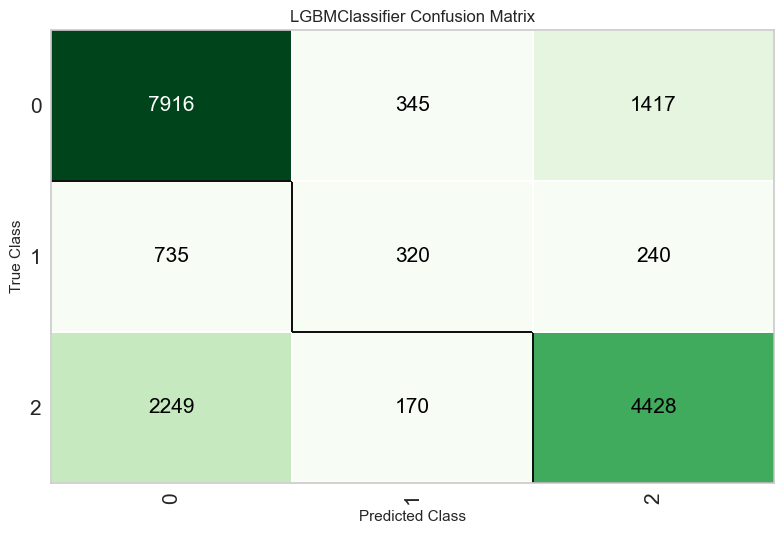

In [9]:
exp.plot_model(best,"confusion_matrix")

In [10]:
pred = exp.predict_model(best,X_test)
X_test_labels_pycaret = pred[["id","prediction_label"]]
X_test_labels_pycaret["prediction_label"] = le.inverse_transform(X_test_labels_pycaret.prediction_label)
X_test_labels_pycaret.rename(columns={"prediction_label":"status_group"},inplace=True)
X_test_labels_pycaret.to_csv("Out/predicciones_pycaret1.csv",index=None,sep=",")

In [11]:
pd.read_csv("Out/predicciones_pycaret1.csv")

,id,status_group
0,50785,functional
1,51630,non functional
2,17168,non functional
3,45559,non functional
4,49871,functional
...,...,...
14845,39307,functional
14846,18990,functional
14847,28749,functional
14848,33492,functional


In [2]:
X = pd.read_csv("In/Training_set_values.csv")
y = pd.read_csv("In/Training_set_labels.csv")
X_test = pd.read_csv("In/Test_set_values.csv")
df = pd.merge(X,y,on="id")



In [3]:
for i in X.select_dtypes(include = "O").columns:
    X[i] = df[i].astype("category")

In [4]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
#df.status_group = le.fit_transform(df.status_group)

In [5]:
y["status_group"] = le.fit_transform(y.status_group)

drop_list  = ["management_group","permit","population","amount_tsh","num_private","recorded_by"]
X.drop(drop_list,axis=1,inplace=True)
X_test.drop(drop_list,axis=1,inplace=True)

cat_cols = X.select_dtypes(exclude=np.number).columns.tolist()
num_cols = X.select_dtypes(include=np.number).columns.tolist()


cat_cols = X.select_dtypes(exclude=np.number).columns.tolist()
cat_cols.append("district_code")
cat_cols.append("region_code")

num_cols = X.select_dtypes(include=np.number).columns.tolist()
num_cols.remove("id")
num_cols.remove("district_code")
num_cols.remove("region_code")

preprocessing = ColumnTransformer([
    ('target_enc', TargetEncoder(), cat_cols),  
    ('scaler', StandardScaler(), num_cols),  
],
remainder = "passthrough",
)
X = pd.DataFrame(data=preprocessing.fit_transform(X,y=y.status_group.values), columns=preprocessing.get_feature_names_out())
X_test = pd.DataFrame(data=preprocessing.transform(X_test), columns=preprocessing.get_feature_names_out())

In [8]:
rf = RandomForestClassifier()
rf.fit(X.to_numpy(),y.status_group.values)

RandomForestClassifier()

In [9]:
X_test["predictions"] = rf.predict(X_test)

/Users/juandavid/anaconda3/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [10]:
X_test.predictions = le.inverse_transform(X_test.predictions)
X_test = X_test[["remainder__id","predictions"]]
X_test.remainder__id = X_test.remainder__id.astype(int)

X_test.rename({"remainder__id":"id","predictions":"status_group"},axis=1,inplace=True)
X_test.to_csv("Out/predicciones_TargetEncoderStandardScaler.csv",index=None,sep=",")

In [82]:
X = pd.read_csv("In/Training_set_values.csv")
y = pd.read_csv("In/Training_set_labels.csv")
X_test = pd.read_csv("In/Test_set_values.csv")
df = pd.merge(X,y,on="id")

for i in X.select_dtypes(include = "O").columns:
    X[i] = df[i].astype("category")


In [84]:
y["status_group"] = le.fit_transform(y.status_group)

drop_list  = ["management_group","permit","population","amount_tsh","num_private","recorded_by"]
X.drop(drop_list,axis=1,inplace=True)
X_test.drop(drop_list,axis=1,inplace=True)

cat_cols = X.select_dtypes(exclude=np.number).columns.tolist()
num_cols = X.select_dtypes(include=np.number).columns.tolist()


cat_cols = X.select_dtypes(exclude=np.number).columns.tolist()
cat_cols.append("district_code")
cat_cols.append("region_code")

num_cols = X.select_dtypes(include=np.number).columns.tolist()
num_cols.remove("id")
num_cols.remove("district_code")
num_cols.remove("region_code")

preprocessing = ColumnTransformer([
    ('target_enc', OrdinalEncoder(handle_unknown="use_encoded_value",
                                  unknown_value=10000000,
                                  encoded_missing_value =10000000), cat_cols),  
    ('scaler', StandardScaler(), num_cols),  
],
remainder = "passthrough",
)
X = pd.DataFrame(data=preprocessing.fit_transform(X,y=y.status_group.values), columns=preprocessing.get_feature_names_out())
X_test = pd.DataFrame(data=preprocessing.transform(X_test), columns=preprocessing.get_feature_names_out())

ValueError: Expected 2D array, got 1D array instead:
array=['functional' 'functional' 'functional' ... 'functional' 'functional'
 'functional'].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [62]:
X.isna().sum()

target_enc__date_recorded            0
target_enc__funder                   0
target_enc__installer                0
target_enc__wpt_name                 0
target_enc__basin                    0
target_enc__subvillage               0
target_enc__region                   0
target_enc__lga                      0
target_enc__ward                     0
target_enc__public_meeting           0
target_enc__scheme_management        0
target_enc__scheme_name              0
target_enc__extraction_type          0
target_enc__extraction_type_group    0
target_enc__extraction_type_class    0
target_enc__management               0
target_enc__payment                  0
target_enc__payment_type             0
target_enc__water_quality            0
target_enc__quality_group            0
target_enc__quantity                 0
target_enc__quantity_group           0
target_enc__source                   0
target_enc__source_type              0
target_enc__source_class             0
target_enc__waterpoint_ty

In [63]:
rf = RandomForestClassifier()
rf.fit(X.to_numpy(),y.status_group.values)
X_test["status_group"] = rf.predict(X_test)
X_test.remainder__id = X_test.remainder__id.astype(int)
X_test.rename({"remainder__id":"id","predictions":"status_group"},axis=1,inplace=True)

/Users/juandavid/anaconda3/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [71]:
X_test = X_test[["id","status_group"]]
X_test.status_group = le.inverse_transform(X_test.status_group)
X_test.to_csv("Out/predicciones_OrdinalEncoderStandardScaler.csv",index=None,sep=",")


# Con Clusters de location, tenía altas espectativas, pero no dio buen resultado

In [93]:
le = OrdinalEncoder()
label_enc = LabelEncoder()
X= pd.read_csv("Out/XReemplazoLongitudeLatitudeConClusters.csv")
y = pd.read_csv("In/Training_set_labels.csv")
X_test = pd.read_csv("Out/X_testReemplazoLongitudeLatitudeConClusters.csv")
df = pd.merge(X,y,on="id")

for i in X.select_dtypes(include = "O").columns:
    X[i] = df[i].astype("category")
    
y["status_group"] = label_enc.fit_transform(y.status_group)

drop_list  = ["management_group","permit","population","amount_tsh","num_private","recorded_by"]
X.drop(drop_list,axis=1,inplace=True)
X_test.drop(drop_list,axis=1,inplace=True)

cat_cols = X.select_dtypes(exclude=np.number).columns.tolist()
num_cols = X.select_dtypes(include=np.number).columns.tolist()


cat_cols = X.select_dtypes(exclude=np.number).columns.tolist()
cat_cols.append("district_code")
cat_cols.append("region_code")

num_cols = X.select_dtypes(include=np.number).columns.tolist()
num_cols.remove("id")
num_cols.remove("district_code")
num_cols.remove("region_code")

preprocessing = ColumnTransformer([
    ('target_enc', OrdinalEncoder(handle_unknown="use_encoded_value",
                                  unknown_value=10000000,
                                  encoded_missing_value =10000000), cat_cols),  
    ('scaler', StandardScaler(), num_cols),  
],
remainder = "passthrough",
)
X = pd.DataFrame(data=preprocessing.fit_transform(X,y=y.status_group.values), columns=preprocessing.get_feature_names_out())
X_test = pd.DataFrame(data=preprocessing.transform(X_test), columns=preprocessing.get_feature_names_out())

rf = RandomForestClassifier()
rf.fit(X.to_numpy(),y.status_group.values)
X_test["status_group"] = rf.predict(X_test)
X_test.remainder__id = X_test.remainder__id.astype(int)
X_test.rename({"remainder__id":"id","predictions":"status_group"},axis=1,inplace=True)


/Users/juandavid/anaconda3/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [96]:
X_test = X_test[["id","status_group"]]
X_test.status_group = label_enc.inverse_transform(X_test.status_group)
X_test.to_csv("Out/predicciones_OrdinalEncoderStandardScaler7ClustersLoc.csv",index=None,sep=",")

ValueError: y contains previously unseen labels: ['functional' 'functional needs repair' 'non functional']

In [ ]:
# GradientBoosting da buenos resultados en cross_validate

In [2]:
X = pd.read_csv("In/Training_set_values.csv")
y = pd.read_csv("In/Training_set_labels.csv")
X_test = pd.read_csv("In/Test_set_values.csv")
df = pd.merge(X,y,on="id")

for i in X.select_dtypes(include = "O").columns:
    X[i] = df[i].astype("category")


In [6]:
le= LabelEncoder()
y["status_group"] = le.fit_transform(y.status_group)

drop_list  = ["management_group","permit","population","amount_tsh","num_private","recorded_by"]
X.drop(drop_list,axis=1,inplace=True)
X_test.drop(drop_list,axis=1,inplace=True)

cat_cols = X.select_dtypes(exclude=np.number).columns.tolist()
num_cols = X.select_dtypes(include=np.number).columns.tolist()


cat_cols = X.select_dtypes(exclude=np.number).columns.tolist()
cat_cols.append("district_code")
cat_cols.append("region_code")

num_cols = X.select_dtypes(include=np.number).columns.tolist()
num_cols.remove("id")
num_cols.remove("district_code")
num_cols.remove("region_code")

preprocessing = ColumnTransformer([
    ('target_enc', OrdinalEncoder(handle_unknown="use_encoded_value",
                                  unknown_value=10000000,
                                  encoded_missing_value =10000000), cat_cols),  
    ('scaler', StandardScaler(), num_cols),  
],
remainder = "passthrough",
)
X = pd.DataFrame(data=preprocessing.fit_transform(X,y=y.status_group.values), columns=preprocessing.get_feature_names_out())
X_test = pd.DataFrame(data=preprocessing.transform(X_test), columns=preprocessing.get_feature_names_out())

In [8]:
gradBoost = GradientBoostingClassifier()
gradBoost.fit(X.to_numpy(),y.status_group.values)
X_test["status_group"] = gradBoost.predict(X_test)
X_test.remainder__id = X_test.remainder__id.astype(int)
X_test.rename({"remainder__id":"id","predictions":"status_group"},axis=1,inplace=True)

/Users/juandavid/anaconda3/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


In [9]:
X_test = X_test[["id","status_group"]]
X_test.status_group = le.inverse_transform(X_test.status_group)
X_test.to_csv("Out/GradBoostpredicciones_OrdinalEncoderStandardScaler.csv",index=None,sep=",")

# Empiezo a probra resampling

## SMOTE not majority

In [16]:
X = pd.read_csv("In/Training_set_values.csv")
y = pd.read_csv("In/Training_set_labels.csv")
X_test = pd.read_csv("In/Test_set_values.csv")
df = pd.merge(X,y,on="id")
sm = SMOTE(random_state=23,sampling_strategy = "not majority")

for i in X.select_dtypes(include = "O").columns:
    X[i] = df[i].astype("category")

le= LabelEncoder()
y["status_group"] = le.fit_transform(y.status_group)

drop_list  = ["management_group","permit","population","amount_tsh","num_private","recorded_by"]
X.drop(drop_list,axis=1,inplace=True)
X_test.drop(drop_list,axis=1,inplace=True)

cat_cols = X.select_dtypes(exclude=np.number).columns.tolist()
num_cols = X.select_dtypes(include=np.number).columns.tolist()


cat_cols = X.select_dtypes(exclude=np.number).columns.tolist()
cat_cols.append("district_code")
cat_cols.append("region_code")

num_cols = X.select_dtypes(include=np.number).columns.tolist()
num_cols.remove("id")
num_cols.remove("district_code")
num_cols.remove("region_code")

preprocessing = ColumnTransformer([
    ('target_enc', OrdinalEncoder(handle_unknown="use_encoded_value",
                                  unknown_value=10000000,
                                  encoded_missing_value =10000000), cat_cols),  
    ('scaler', StandardScaler(), num_cols),  
],
remainder = "passthrough",
)
X = pd.DataFrame(data=preprocessing.fit_transform(X,y=y.status_group.values), columns=preprocessing.get_feature_names_out())
X_test = pd.DataFrame(data=preprocessing.transform(X_test), columns=preprocessing.get_feature_names_out())

X, y = sm.fit_resample(X, y.status_group.values)

rf = RandomForestClassifier()
rf.fit(X.to_numpy(),y)
X_test["status_group"] = rf.predict(X_test)
X_test.remainder__id = X_test.remainder__id.astype(int)
X_test.rename({"remainder__id":"id","predictions":"status_group"},axis=1,inplace=True)

/Users/juandavid/anaconda3/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [17]:
X_test = X_test[["id","status_group"]]
X_test.status_group = le.inverse_transform(X_test.status_group)
X_test.to_csv("Out/RandomForestSMOTEnot_majority.csv",index=None,sep=",")

## SMOTE minority

In [19]:
X = pd.read_csv("In/Training_set_values.csv")
y = pd.read_csv("In/Training_set_labels.csv")
X_test = pd.read_csv("In/Test_set_values.csv")
df = pd.merge(X,y,on="id")
sm = SMOTE(random_state=23,sampling_strategy = "minority")

for i in X.select_dtypes(include = "O").columns:
    X[i] = df[i].astype("category")

le= LabelEncoder()
y["status_group"] = le.fit_transform(y.status_group)

drop_list  = ["management_group","permit","population","amount_tsh","num_private","recorded_by"]
X.drop(drop_list,axis=1,inplace=True)
X_test.drop(drop_list,axis=1,inplace=True)

cat_cols = X.select_dtypes(exclude=np.number).columns.tolist()
num_cols = X.select_dtypes(include=np.number).columns.tolist()


cat_cols = X.select_dtypes(exclude=np.number).columns.tolist()
cat_cols.append("district_code")
cat_cols.append("region_code")

num_cols = X.select_dtypes(include=np.number).columns.tolist()
num_cols.remove("id")
num_cols.remove("district_code")
num_cols.remove("region_code")

preprocessing = ColumnTransformer([
    ('target_enc', OrdinalEncoder(handle_unknown="use_encoded_value",
                                  unknown_value=10000000,
                                  encoded_missing_value =10000000), cat_cols),  
    ('scaler', StandardScaler(), num_cols),  
],
remainder = "passthrough",
)
X = pd.DataFrame(data=preprocessing.fit_transform(X,y=y.status_group.values), columns=preprocessing.get_feature_names_out())
X_test = pd.DataFrame(data=preprocessing.transform(X_test), columns=preprocessing.get_feature_names_out())

X, y = sm.fit_resample(X, y.status_group.values)

rf = RandomForestClassifier()
rf.fit(X.to_numpy(),y)
X_test["status_group"] = rf.predict(X_test)
X_test.remainder__id = X_test.remainder__id.astype(int)
X_test.rename({"remainder__id":"id","predictions":"status_group"},axis=1,inplace=True)

/Users/juandavid/anaconda3/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [20]:
X_test = X_test[["id","status_group"]]
X_test.status_group = le.inverse_transform(X_test.status_group)
X_test.to_csv("Out/RandomForestSMOTEminority.csv",index=None,sep=",")

In [ ]:
# queda por intentar con más técnicas, dejando clusters y continuas